In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import urllib.request
import os
import shutil
import tarfile
import matplotlib.pyplot as plt
from sklearn import datasets, cross_validation, metrics
from sklearn.preprocessing import KernelCenterer
from scipy.linalg import svd

%matplotlib inline

### Kernel Null Foley-Sammon Transform for Novelty Detection




The following function calculates the basis for the nullspace of a given matrix A.

In [2]:
def nullspace(A, eps=1e-12):
    u, s, vh = svd(A)
    null_mask = (s <= eps)
    null_space = sp.compress(null_mask, vh, axis=0)
    return sp.transpose(null_space)

Train the model, and obtain the projection and class target points.

In [3]:
def learn(K, labels):
    '''
    Calculate multi-class KNFST model for multi-class novelty detection
    
    INPUT
      K: NxN kernel matrix containing similarities of n training samples
      labels: Nx1 column vector containing multi-class labels of N training samples

    OUTPUT
      proj: Projection of KNFST
      target_points: The projections of training data into the null space

    '''
    classes = np.unique(labels)
    if len(classes) < 2:
        raise Exception("KNFST requires 2 or more classes")
    n, m = K.shape
    if n != m:
        raise Exception("Kernel matrix must be quadratic")
    
    centered_k = KernelCenterer().fit_transform(K)
    
    basis_values, basis_vecs = np.linalg.eigh(centered_k)
    
    basis_vecs = basis_vecs[:,basis_values > 1e-12]
    basis_values = basis_values[basis_values > 1e-12]
 
    basis_values = np.diag(1.0/np.sqrt(basis_values))

    basis_vecs  = basis_vecs.dot(basis_values)

    L = np.zeros([n,n])
    for cl in classes:
        for idx1, x in enumerate(labels == cl):
            for idx2, y in enumerate(labels == cl):
                if x and y:
                    L[idx1, idx2] = 1.0/np.sum(labels==cl)
    M = np.ones([m,m])/m
    H = (((np.eye(m,m)-M).dot(basis_vecs)).T).dot(K).dot(np.eye(n,m)-L)
    
    t_sw = H.dot(H.T)
    eigenvecs = nullspace(t_sw)
    if eigenvecs.shape[1] < 1:
        eigenvals, eigenvecs = np.linalg.eigh(t_sw)
        
        eigenvals = np.diag(eigenvals)
        min_idx = eigenvals.argsort()[0]
        eigenvecs = eigenvecs[:, min_idx]
    proj = ((np.eye(m,m)-M).dot(basis_vecs)).dot(eigenvecs)
    target_points = []
    for cl in classes:
        k_cl = K[labels==cl, :]        
        pt = np.mean(k_cl.dot(proj), axis=0)
        target_points.append(pt)
        
    return proj, np.array(target_points)

In [4]:
def squared_euclidean_distances(x, y):
    n = np.shape(x)[0]
    m = np.shape(y)[0]
    distmat = np.zeros((n,m))
    
    for i in range(n):
        for j in range(m):
            buff = x[i,:] - y[j,:]
            distmat[i,j] = buff.dot(buff.T)
    return distmat

In [5]:
def assign_score(proj, target_points, ks):
    projection_vectors = ks.T.dot(proj)
    sq_dist = squared_euclidean_distances(projection_vectors, target_points)
    scores = np.sqrt(np.amin(sq_dist, 1))
    return scores

In [6]:
def normalise_z(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    assert np.any(sigma > 0.0), 'Zero variance'
    return (data-mu)/sigma

In [7]:
def _hik(x, y):
    '''
    Implements the histogram intersection kernel.
    '''
    return np.minimum(x, y).sum()

In [8]:
def median_pairwise_distance(X, Y):
    distances = metrics.pairwise_distances(X, Y)
    return np.median(distances)

In [9]:
def run_tests(data, target, known_train_size=0.9, num_tests=30, **kernel_args):
    classes = np.unique(target)
    auc_scores = []
    for n in range(num_tests):
        num_class = len(classes)
        num_known = max(int(np.floor(num_class/2)), 2)
        known = np.random.choice(classes, num_known, replace=False)
        mask = np.array([y in known for y in target])

        X_train = data[mask]
        y_train = target[mask]

        idx = np.arange(len(y_train))
        np.random.shuffle(idx) 
        num_train = len(X_train)
        X_train = X_train[idx < num_train*known_train_size]
        y_train = y_train[idx < num_train*known_train_size]

    #     sample_idx = np.random.randint(0, len(data), size=len(data)//2)
        X_test = data
        y_labels = target

        # Test labels are 1 if novel, otherwise 0.
        y_test = np.array([1 if cl not in known else 0 for cl in y_labels])

        # Train model
        if kernel_args.get("metric") =="rbf":
            median_dist = median_pairwise_distance(X_train, X_train)
            kernel_args["gamma"] = median_dist
            
        kernel_mat = metrics.pairwise_kernels(X_train, **kernel_args)
        proj, target_points = learn(kernel_mat, y_train)

        # Test
        if kernel_args.get("metric") =="rbf":
            median_dist = median_pairwise_distance(X_train, X_test)
            kernel_args["gamma"] = median_dist
        
        ks = metrics.pairwise_kernels(X_train, X_test, **kernel_args)
        scores = assign_score(proj, target_points, ks)

        auc = metrics.roc_auc_score(y_test, scores)
        auc_scores.append(auc)
    return auc_scores

In [10]:
def retrieve_dataset(url, dataset_dir="../data", filename=None, extract_targiz=False):
    if not filename:
        filename = os.path.split(url)[1]
        
    dest_path = os.path.join(dataset_dir, filename)

    if os.path.exists(dest_path):
        print("{} exists. Skipping download...".format(dest_path))
    else:
        with urllib.request.urlopen(url) as response, open(dest_path, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
            print("Dataset downloaded. Extracting files...")

    if extract_targiz:
        tar = tarfile.open(dest_path)
        tar.extractall(path=dataset_dir)
        print("Files extracted.")
        tar.close()
    
    return dest_path

Dataset downloaded. Extracting files...


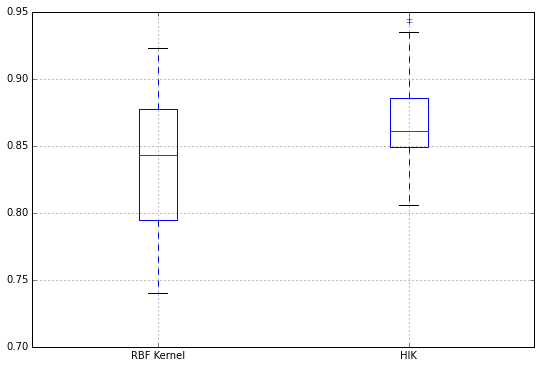

In [11]:
url = r"http://mldata.org/repository/data/download/csv/glass/"
path = retrieve_dataset(url, filename="glass.csv")

csv_data = np.loadtxt(path, delimiter=",")
raw_data = csv_data[:,1:]
data = normalise_z(raw_data)
target = csv_data[:,0].astype(int)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

rbf_result = run_tests(data, target, known_train_size=0.6, metric="rbf")
hik_result = run_tests(data, target, known_train_size=0.6, metric=_hik)
bp = ax.boxplot([rbf_result, hik_result])
ax.set_xticklabels(['RBF Kernel', 'HIK'])
ax.grid(True)
plt.show()

Dataset downloaded. Extracting files...


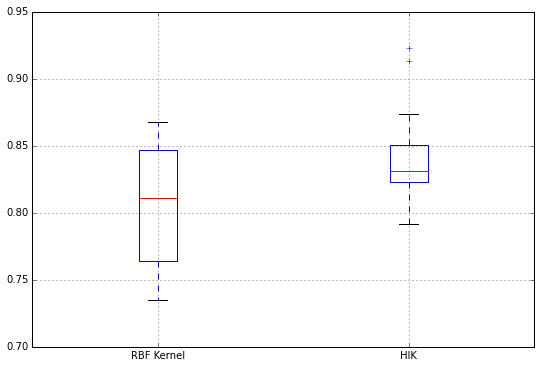

In [12]:
url = r"http://mldata.org/repository/data/download/csv/vehicle/"
path = retrieve_dataset(url, filename="vehicle.csv")

csv_data = np.loadtxt(path, delimiter=",")
raw_data = csv_data[:,1:]
data = normalise_z(raw_data)
target = csv_data[:,0].astype(int)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

rbf_result = run_tests(data, target, known_train_size=0.6, metric="rbf")
hik_result = run_tests(data, target, known_train_size=0.6, metric=_hik)
bp = ax.boxplot([rbf_result, hik_result])
ax.set_xticklabels(['RBF Kernel', 'HIK'])
ax.grid(True)
plt.show()

Dataset downloaded. Extracting files...


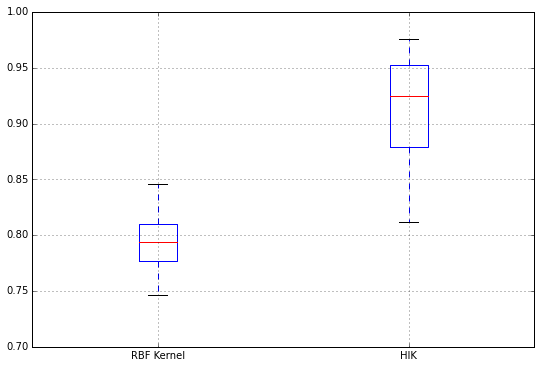

In [13]:
url = r"http://mldata.org/repository/data/download/csv/wine/"
path = retrieve_dataset(url, filename="wine.csv")

csv_data = np.loadtxt(path, delimiter=",")
raw_data = csv_data[:,1:]
data = normalise_z(raw_data)
target = csv_data[:,0].astype(int)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

rbf_result = run_tests(data, target, known_train_size=0.6, metric="rbf")
hik_result = run_tests(data, target, known_train_size=0.6, metric=_hik)
bp = ax.boxplot([rbf_result, hik_result])
ax.set_xticklabels(['RBF Kernel', 'HIK'])
ax.grid(True)
plt.show()

Tests on the Caltech256 dataset:

In [14]:
path = os.path.join(DATASET_DIR, "bow_1000_dense/")

ds = datasets.load_files(path)
ds.data = np.vstack([np.fromstring(txt, sep='\t') for txt in ds.data])

data = ds.data
target = ds.target

NameError: name 'DATASET_DIR' is not defined

In [ ]:
def plot_score(scores, y_test):
    colours = ['r', 'b']
    for y, colour in zip([0, 1], colours):
        m = y_test == y
        plt.scatter(scores[m], y_test[m], color=colour)
#     plt.plot(scores, np.zeros_like(scores), 'x')
    plt.show()